In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import copy
import json

from viz_functions import plot_extra_steps_from_file, plot_steps, plot_extra_steps_from_pandas

import sys
sys.path.append('../..')
from src.pomdp import *

# Test setup

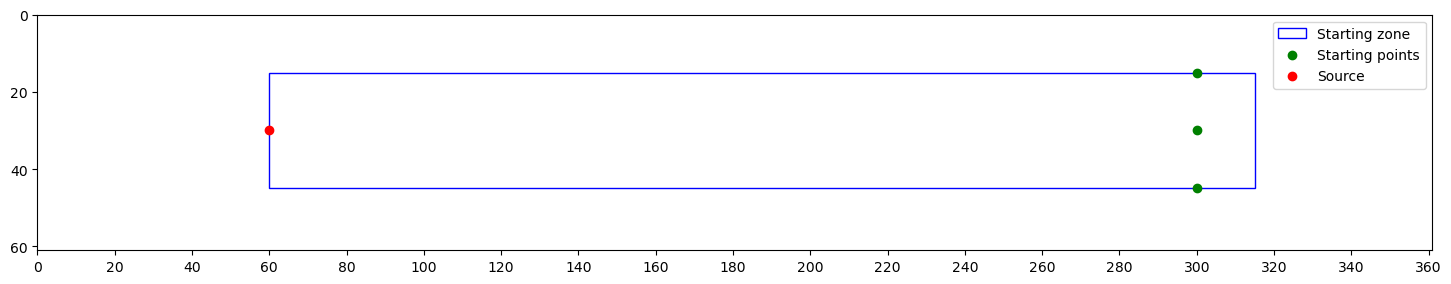

In [2]:
fig, ax = plt.subplots(figsize=(18,5))

ax.set_xlim(0,361)
ax.set_xticks(np.arange(0,361,20))
ax.set_ylim(0,61)
ax.set_yticks(np.arange(0,61,20))
ax.invert_yaxis()

ax.set_aspect('equal')

# Starting zone
ax.add_patch(Rectangle([60, 15], width=8.5*30, height=30, linewidth=1, edgecolor='b', facecolor='none', label='Starting zone'))

# Starting points
ax.scatter([300,300,300], [15,30,45], c='green', label='Starting points')

# Goal point
ax.scatter(x=60, y=30, color='red', label='Source')

ax.legend()

# Visualize Path

In [3]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')

In [4]:
ground_air_test_run = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/Simulations/run-3-sims.csv'
simulations_df = pd.read_csv(ground_air_test_run, index_col=0)

sims = []
for col in simulations_df.columns:
    sim_steps = simulations_df[col].tolist()
    sim_steps = [json.loads(step) for step in sim_steps if isinstance(step, str)]

    # Creation of simulation history
    sim_hist = SimulationHistory(model, sim_steps[0]['s'], Belief(model))

    sim_hist.states = [step['s'] for step in sim_steps]
    sim_hist.actions = [step['a'] for step in sim_steps]
    sim_hist.observations = [step['o'] for step in sim_steps]
    sim_hist.rewards = [step['r'] for step in sim_steps]

    sims.append(sim_hist)

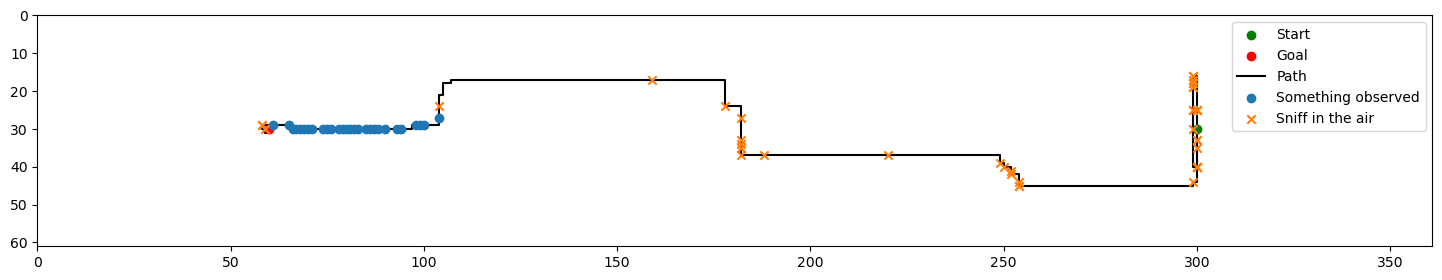

In [5]:
plot_steps(sims[0], until_step=500)

## Video

In [6]:
def plot_steps_mod(sim_hist:SimulationHistory, until_step:int=-1, ax=None) -> None:
    '''
    Plots a special version of the simulation plot for olfactory navigation
    
    Parameters
    ----------
    sim_hist : SimulationHistory
        The completed simulation history.
    ax : optional
        The ax the produce the plot on, if not a new one will be created.
    '''
    # Generate ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(18,3))

    # Initial clearing
    ax.clear()

    # Get cpu model
    model = sim_hist.model.cpu_model

    # Until step
    if until_step < 0:
        until_step = len(seq) - 1

    # Casting or surging
    status = None
    length = 5
    shift = 0
    while until_step - shift > length and status is None:
        if all(np.isin(sim_hist.actions[until_step-shift-length:until_step-shift], [0,2,4,5])): # Casting
            status = 'Casting'
        if all(np.isin(sim_hist.actions[until_step-shift-length:until_step-shift], [3,4,5])): # Surging
            status = 'Surging'

        shift += 1

    # Plot setup
    env_shape = model.cpu_model.state_grid.shape
    ax.set_xlim(0, env_shape[1])
    ax.set_ylim(env_shape[0], 0)

    # Agent
    start_coord = sim_hist.grid_point_sequence[until_step]
    ax.scatter(start_coord[1], start_coord[0], c='green', label='Start', zorder=10)

    # Goal
    goal_coord = np.array([np.argwhere(model.state_grid == g)[0].tolist() for g in model.end_states])
    ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

    # Path
    seq = np.array(sim_hist.grid_point_sequence)
    ax.plot(seq[:until_step+1,1], seq[:until_step+1,0], zorder=-1, c='black', label='Path')

    # Something sensed
    something_obs_id = model.observation_labels.index('something')
    obs_ts = np.where(np.array(sim_hist.observations[:until_step]) == something_obs_id)
    points_obs = seq[obs_ts[0],:]
    ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

    # Points sniff
    sniff_air_action_id = -1
    for i, al in enumerate(model.action_labels):
        if 'air' in al.lower():
            sniff_air_action_id = i
    sniff_in_air = np.where(np.array(sim_hist.actions[:until_step]) == sniff_air_action_id)
    points_sniff = seq[sniff_in_air[0],:]
    if len(points_sniff) > 0:
        ax.scatter(points_sniff[:,1], points_sniff[:,0], zorder=2, marker='x', label='Sniff in the air')

    # Generate legend
    # ax.legend()

    if status is not None:
        ax.annotate(status, (5,5), weight='bold', size=14)

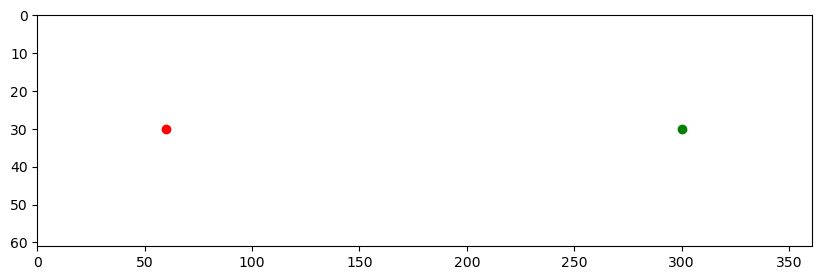

In [7]:
fig = plt.figure(figsize=(10,3))
ax = plt.gca()
steps = len(sims[0].states)

ani = animation.FuncAnimation(fig, (lambda frame_i: plot_steps_mod(sims[0], until_step=frame_i, ax=ax)), frames=steps, interval=1, repeat=False)

writervideo = animation.FFMpegWriter(fps=20)
ani.save('./Sim Videos/' + 'sim_run3.mp4', writer=writervideo)

# Visualize extra steps

## Ground only

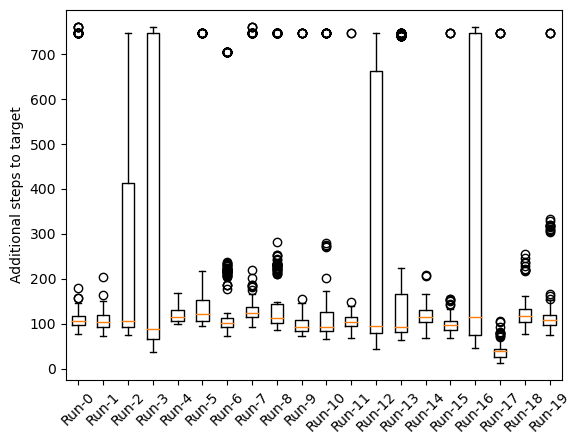

In [8]:
ground_file = './Test_Results/Test_Ground_FSVI_300it_100exp_099g_e6eps_20run_20231120_141253/extra_steps.csv'
plot_extra_steps_from_file(ground_file)

### Filtered unfinishes trajectories

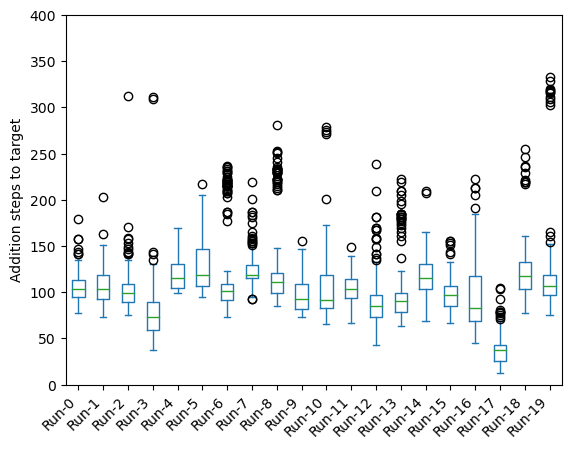

In [9]:
# Plot filtered version
df = pd.read_csv(ground_file)
df = df.drop(columns='Average')

extra_steps_array = df.to_numpy().T
extra_steps_df = pd.DataFrame(extra_steps_array, columns=[f'Run-{i}' for i in range(extra_steps_array.shape[1])])

# Filtered
filt_extra_steps_df = copy.copy(extra_steps_df)
for i in range(extra_steps_array.shape[1]):
    filt_extra_steps_df.loc[filt_extra_steps_df[f'Run-{i}']>600, [f'Run-{i}']] = np.nan

filt_extra_steps_df.plot(kind='box')
plt.ylim(0,400)
plt.ylabel('Addition steps to target')
plt.xticks(rotation=45, ha='right')
plt.show()

### Test 11-27

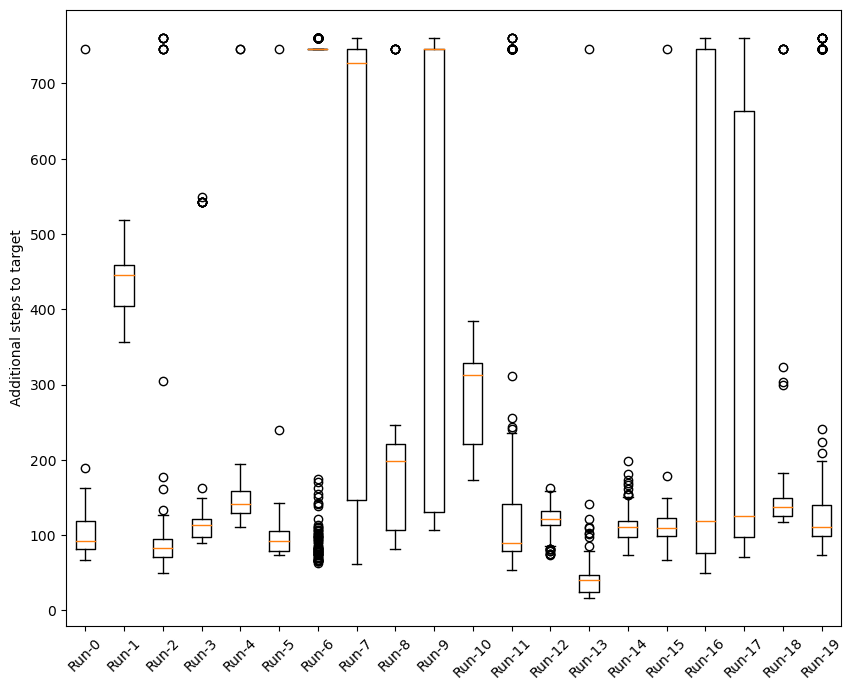

In [22]:
# Saved as: perf_var_ground.png
file = './Test_Results/Test_Ground_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231127_185934/extra_steps.csv'
fig, ax = plt.subplots(figsize=(10,8))
plot_extra_steps_from_file(file, ax=ax)

## Ground and air

### Test 11-21 (1)

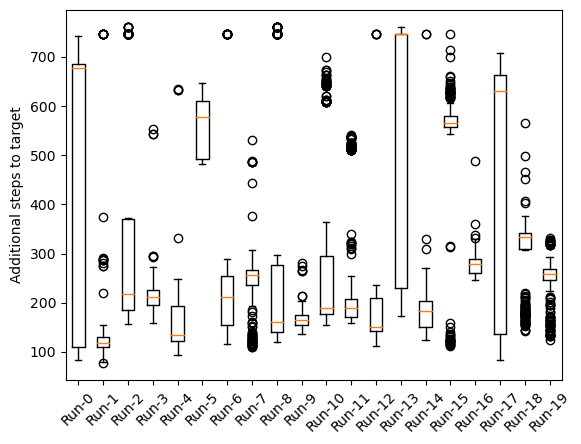

In [10]:
file = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_102752/extra_steps.csv'
plot_extra_steps_from_file(file)

### Test 11-21 (2)

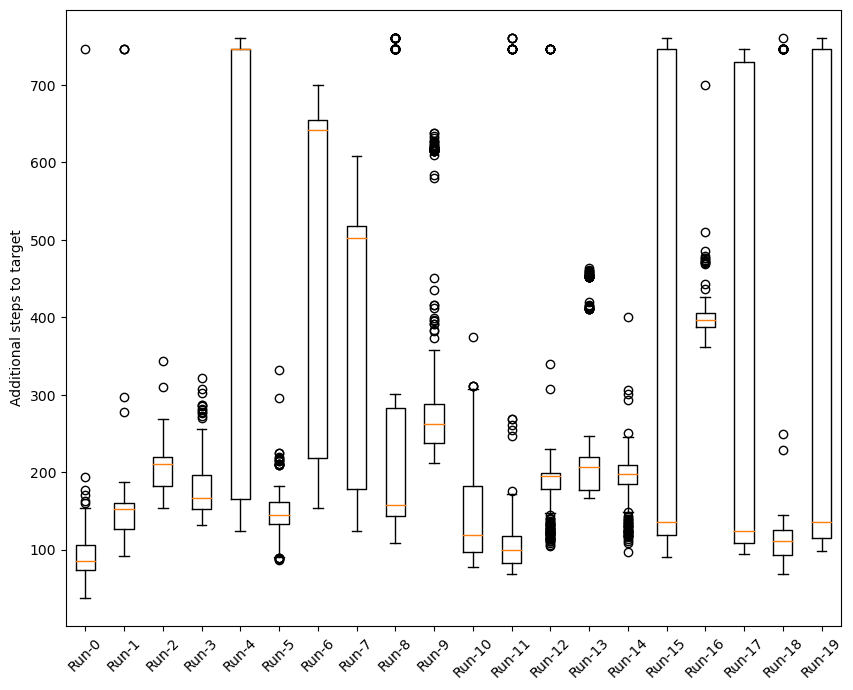

In [11]:
# Saved as: per_var_ground_air.png
file = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/extra_steps.csv'
fig, ax = plt.subplots(figsize=(10,8))
plot_extra_steps_from_file(file, ax=ax)

## Comparing different amount of expansions

In [12]:
files = {
    60: './Test_Results/Test_GroundAir_FSVI_400it_60exp_099g_e6eps_20run_20231122_124320/extra_steps.csv',
    80: './Test_Results/Test_GroundAir_FSVI_400it_80exp_099g_e6eps_20run_20231122_010724/extra_steps.csv',
    100: './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/extra_steps.csv',
    120: './Test_Results/Test_GroundAir_FSVI_400it_120exp_099g_e6eps_20run_20231122_175226/extra_steps.csv'
}

average_sets = {
    e: pd.read_csv(file)['Average'].to_list() for e, file in files.items()
}

Text(0.5, 0, 'Expansion counts')

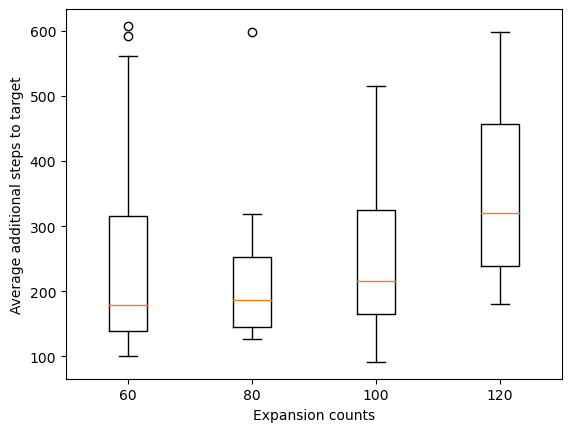

In [13]:
# Saved as: perf_expansions_ground_air.png
# Actual plot
plt.boxplot(list(average_sets.values()), vert=True, widths=0.3)
plt.xticks(np.arange(4)+1, ['60', '80', '100', '120'])

# pd.DataFrame(average_sets).plot(kind='box')
plt.ylabel('Average additional steps to target')
plt.xlabel('Expansion counts')

## Vertical wrap only ground and air

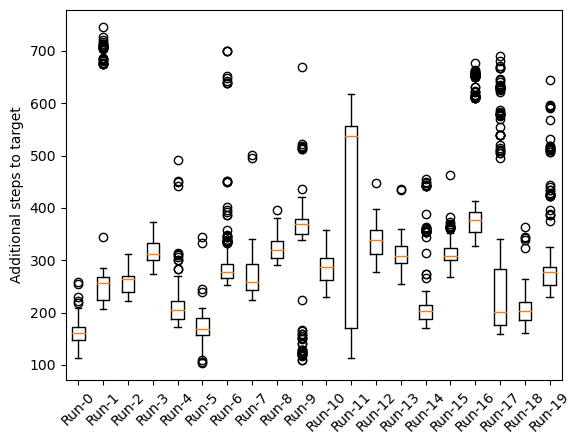

In [14]:
file = './Test_Results/Test_VertGroundAir_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231125_230106/extra_steps.csv'
plot_extra_steps_from_file(file)

## Vertical wrap only ground only

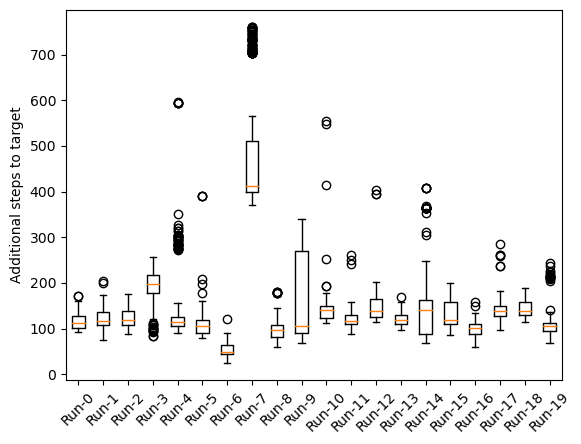

In [15]:
file = './Test_Results/Test_VertGround_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231125_230820/extra_steps.csv'
plot_extra_steps_from_file(file)

## All wrap or vert only ground and air

In [16]:
all_file = './Test_Results/Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_102752/extra_steps.csv'
vert_file = './Test_Results/Test_VertGroundAir_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231125_230106/extra_steps.csv'

In [17]:
all_df = pd.read_csv(all_file)['Average'].to_list()
vert_df = pd.read_csv(vert_file)['Average'].to_list()

Text(0, 0.5, 'Average additional steps to target')

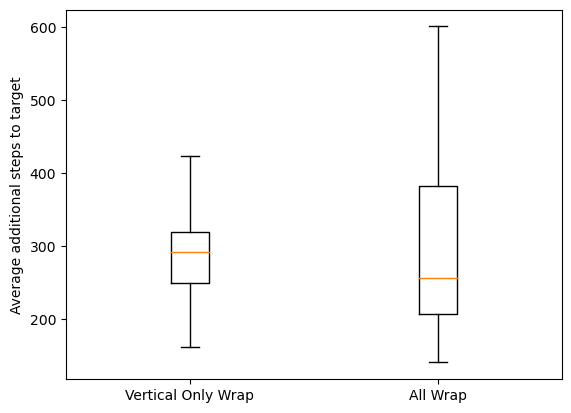

In [18]:
# Saved as: perf_vert_or_not_ground_air.png
plt.boxplot([vert_df, all_df])
plt.xticks(np.arange(2)+1, ['Vertical Only Wrap', 'All Wrap'])
plt.ylabel('Average additional steps to target')

## All wrap or vert only ground only

In [19]:
all_file = './Test_Results/Test_Ground_FSVI_300it_100exp_099g_e6eps_20run_20231120_141253/extra_steps.csv'
vert_file = './Test_Results/Test_VertGround_fsvi_300it_100exp_099g_1e-06eps_20run_300sim_20231125_230820/extra_steps.csv'

In [20]:
all_df = pd.read_csv(all_file)['Average'].to_list()
vert_df = pd.read_csv(vert_file)['Average'].to_list()

Text(0, 0.5, 'Average additional steps to target')

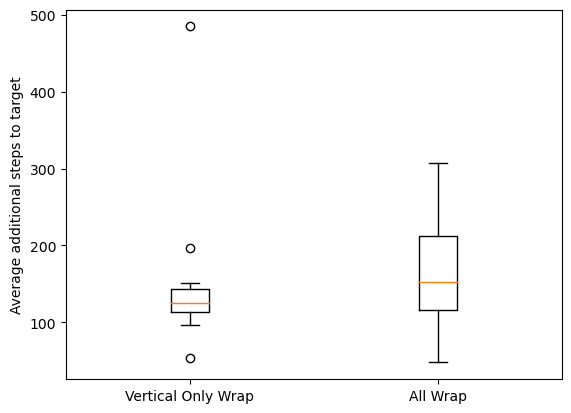

In [21]:
# Saved as: perf_vert_or_not_ground_only.png
plt.boxplot([vert_df, all_df])
plt.xticks(np.arange(2)+1, ['Vertical Only Wrap', 'All Wrap'])
plt.ylabel('Average additional steps to target')

In [24]:
files = {
    'Ground Air': './Test_Results/Test_ProgGroundAir_fsvi_300it_100exp_099g_1e-06eps_30run_300sim_20231126_010006/extra_steps.csv',
    'Ground': './Test_Results/Test_ProgGround_fsvi_300it_100exp_099g_1e-06eps_30run_300sim_20231126_010344/extra_steps.csv',
    'Vert Ground Air': './Test_Results/Test_ProgVertGroundAir_fsvi_300it_100exp_099g_1e-06eps_30run_300sim_20231126_010553/extra_steps.csv',
    'Vert Ground': './Test_Results/Test_ProgVertGround_fsvi_300it_100exp_099g_1e-06eps_30run_300sim_20231126_010508/extra_steps.csv'
}
average_perfs = {
    k: pd.read_csv(v)['Average'].to_list() for k,v in files.items()
}

Text(0.5, 0, 'Training time')

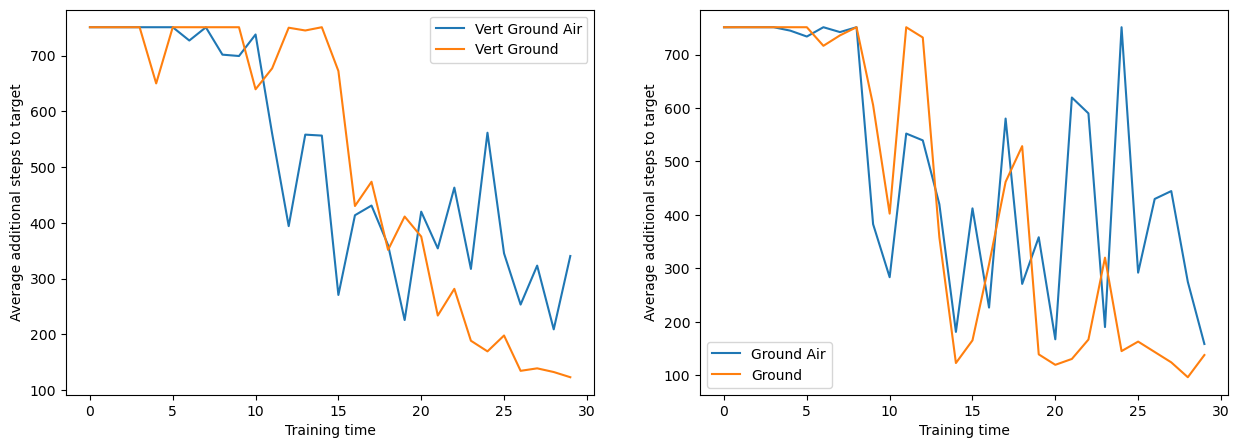

In [25]:
# Saved as: training_process_vert_and_reg.png
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

for name, averages in average_perfs.items():
    ax = ax1 if 'Vert' in name else ax2
    ax.plot(np.arange(len(averages)), averages, label=name)

ax1.legend()
ax1.set_ylabel('Average additional steps to target')
ax1.set_xlabel('Training time')

ax2.legend()
ax2.set_ylabel('Average additional steps to target')
ax2.set_xlabel('Training time')